# Grouping social media posts based on text features.

The goal of this demo session is to cluster a set of posts collected from Twitter. We will use the textual content of each tweet to extract features through the TF-IDF technique. These features are used from the k-means clustering algorithm to group tweets with similar content.

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import os

#### Loading the data

In [11]:
tweets = pd.read_excel('sample_tweets.xlsx')

tweets = tweets[['text_nousernames', 'eduskunta-vkk']]

# renaming columns for better reading
tweets.rename(columns = {"text_nousernames":"text", "eduskunta-vkk":"label"}, inplace=True)

tweets

,text,label
0,RT : Credit where due. Biden warned of the Ru...,"eurooppa-, kulttuuri- ja urheiluministeri"
1,RT : I look forward to welcoming Sweden and F...,"eurooppa-, kulttuuri- ja urheiluministeri"
2,"RT : ""Hätten wir damals wegen der Krim stärke...","eurooppa-, kulttuuri- ja urheiluministeri"
3,RT : My deepest condolences for the victims a...,"eurooppa-, kulttuuri- ja urheiluministeri"
4,RT : Thank you Kamala Harris and \n for an...,"eurooppa-, kulttuuri- ja urheiluministeri"
...,...,...
1163,RT : Facebookissa K-studio https://t.co/qFL2P...,elinkeinoministeri
1164,RT : Ministeri Mika Lintilä antoi itselleen a...,elinkeinoministeri
1165,Kiitokset Jorma asiantuntemuksestasi Suomen ...,elinkeinoministeri
1166,emme ole kirjeessä mukana koska kannattama...,elinkeinoministeri


### Data Preprocessing

First, we preprocess the textual content of each tweet. There are many techniques we could use to clean the data but given the relatively short length of the average tweet's content, we only consider converting the text field of each rating to lowercase.

In [12]:
tweets['text'] = tweets['text'].apply(str.lower)

___
Next, let's take a look at the distribution of labels:

<Axes: >

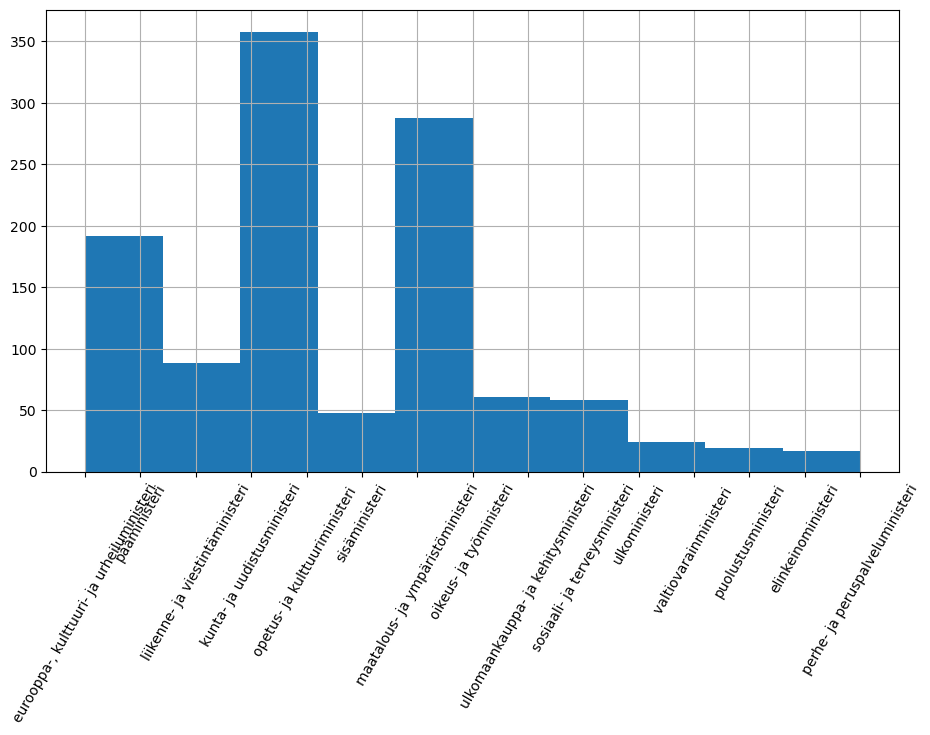

In [13]:
# tweets['label'].unique()
plt.xticks(rotation=60)

tweets['label'].hist(figsize=(11,6))


____
There are various methods to extract features out of textual data. Such techniques are known as text representation methods. Here we list two popular and relatively simple approaches to the word representation problem:

- Among the simplest ones is the Bag-of-Words(BoW) technique. Through this approach we can represent a text (such as a sentence or a document) as the "bag" comprised of its words, ignoring the grammar and the word order. <br/> Ex: "the quick brown fox jumps over the lazy dog" ==> <br/>{'the':2, 'quick':1, 'brown':1, 'fox':1, 'jumps':1, 'over':1, 'lazy':1, 'dog':1}
- TF-IDF stands for "Term Frequency - Inverse Document Frequency". This approach is build on top of the BoW technique. The count(frequency) of each word in a document is normalized by the number of times that each specific word appears over the set of all documents. In this way, popular words appearing among multiple documents will get lower tf-idf score.

In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
# suppress errors when dividing by 0
np.seterr(divide='ignore', invalid='ignore')


{'divide': 'ignore', 'over': 'warn', 'under': 'ignore', 'invalid': 'ignore'}

In [15]:
vectorizer = TfidfVectorizer()
reprs = vectorizer.fit_transform(tweets['text'])
vectorizer.get_feature_names_out()

array(['00', '000', '02', ..., 'överiksi', 'über', 'šiõǥǥ'],
      shape=(9081,), dtype=object)

In [16]:
# Convert sparse arrays to dense ones and normalize the values of each vector in repr to be of unit length.
# Our clustering algorithm uses euclidean-distance to group similar vectors together. By performing the following
# normalization we get the equivalent effect as if we would group them based on the cosine distance.
reprs = reprs.toarray()
length = np.sqrt((reprs**2).sum(axis=1))[:,None]
reprs = reprs / length

# replace Inf and Nan values
reprs = np.nan_to_num(reprs, nan=0.0, posinf=0.0, neginf=0.0)

print('The shape of the matrix containing the word representations is:', reprs.shape)

The shape of the matrix containing the word representations is: (1168, 9081)


In [17]:
# print example features
# reprs[0].tolist()

### Clustering the tweets 

K-means is an unsupervised clustering algorithm. Given a set of **n** vectors, k-means will group them into **k** groups/clusters while trying to keep the variance(distance) between vectors of the same group small. For our use-case, we will use the tf-idf generated representations as the input vectors. 

In [18]:
from sklearn.cluster import KMeans
import numpy as np

k = 10
kmeans = KMeans(n_clusters=k, random_state=12)
clusters = kmeans.fit_predict(reprs)

print(clusters)

[1 9 6 ... 3 7 5]


In [19]:
tweets['cluster_id'] = clusters

tweets['cluster_id'].value_counts()

cluster_id
6    359
2    158
7    141
5    130
8     96
0     82
1     65
3     55
9     47
4     35
Name: count, dtype: int64

### Visualizing the results

____
Now we will plot each rating on a 2d scatter-plot. Currently, the length/dimensions of the representation vectors is more than 9000. We will use the PCA dimensionality reduction tool to reduce the number of dimensions to 2. In the [tutorials folder](https://github.com/InfoTUNI/joda2022/tree/master/tutorials) you may find a more detailed explanation of the PCA technique. 



In [23]:
from sklearn.decomposition import PCA

# Initialize PCA with 2 components, for 2d visualising.
pca = PCA(n_components=2)

# Reduce representation vectors
reducedX = pca.fit_transform(reprs)

C:\Users\Z240\AppData\Local\Temp\ipykernel_14984\1743394457.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  color_map = lambda cid: plt.cm.get_cmap('hsv', k)(cid)


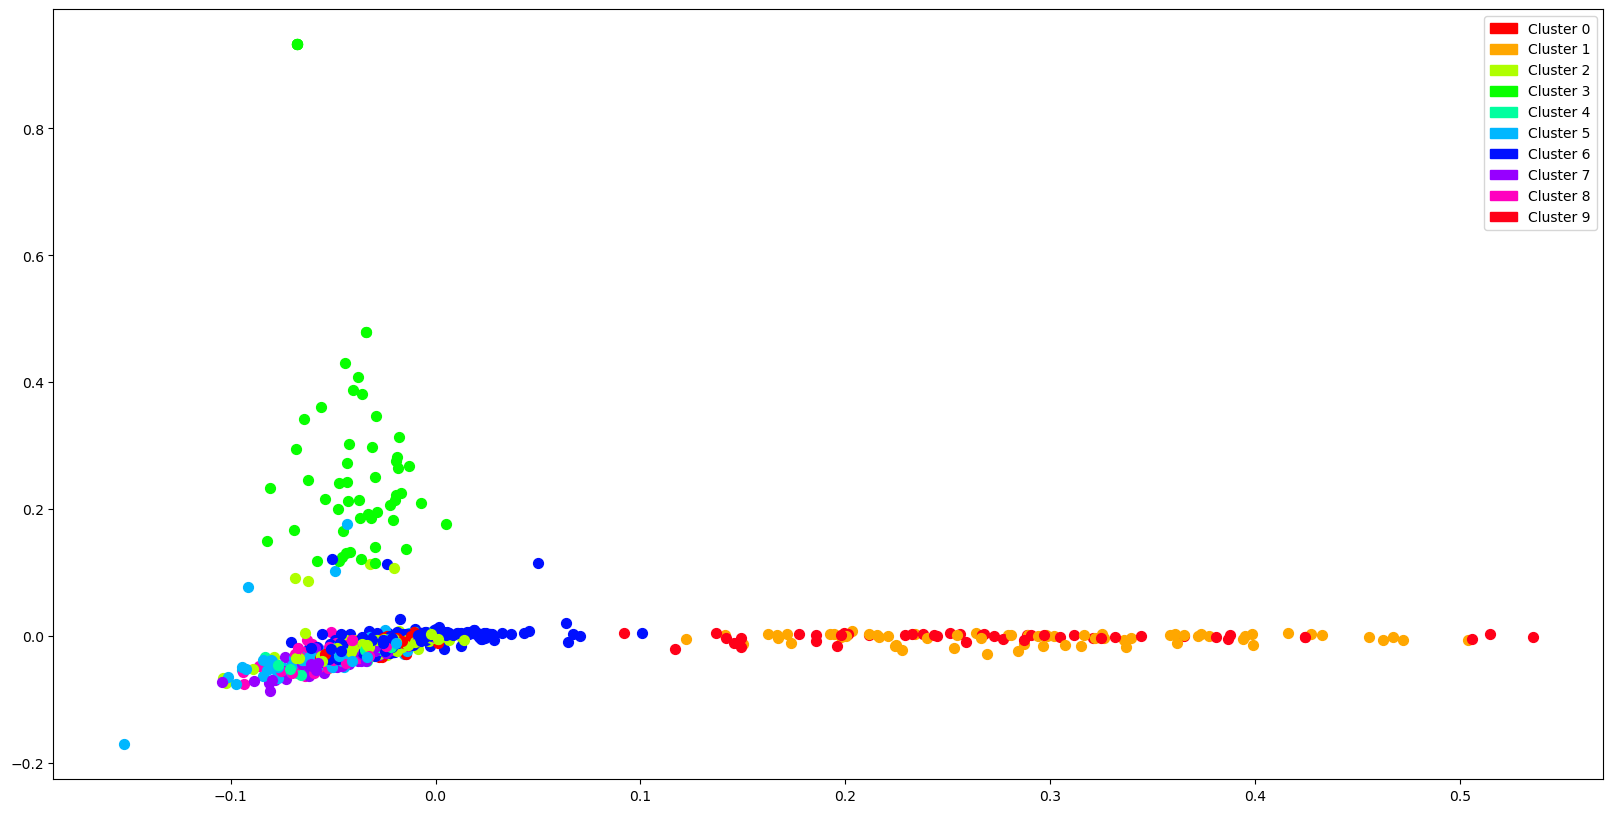

In [24]:
fig, ax = plt.subplots(figsize=(20, 10))

# generate k colors
color_map = lambda cid: plt.cm.get_cmap('hsv', k)(cid)

for dp, cid in zip(reducedX, clusters):
    ax.scatter(dp[0], dp[1], s=50, color=color_map(cid))

    
plt.legend(handles=[
                        mpatches.Patch(color=color_map(cid), label='Cluster '+str(cid)) for cid in range(k)
        ])
plt.show()

In [25]:
# TASK: Visualize the label distribution for 3 clusters that you find most interesting.

C:\Users\Z240\AppData\Local\Temp\ipykernel_14984\1743394457.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  color_map = lambda cid: plt.cm.get_cmap('hsv', k)(cid)
C:\Users\Z240\AppData\Local\Temp\ipykernel_14984\1743394457.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  color_map = lambda cid: plt.cm.get_cmap('hsv', k)(cid)
C:\Users\Z240\AppData\Local\Temp\ipykernel_14984\1743394457.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  color_map = lambda c

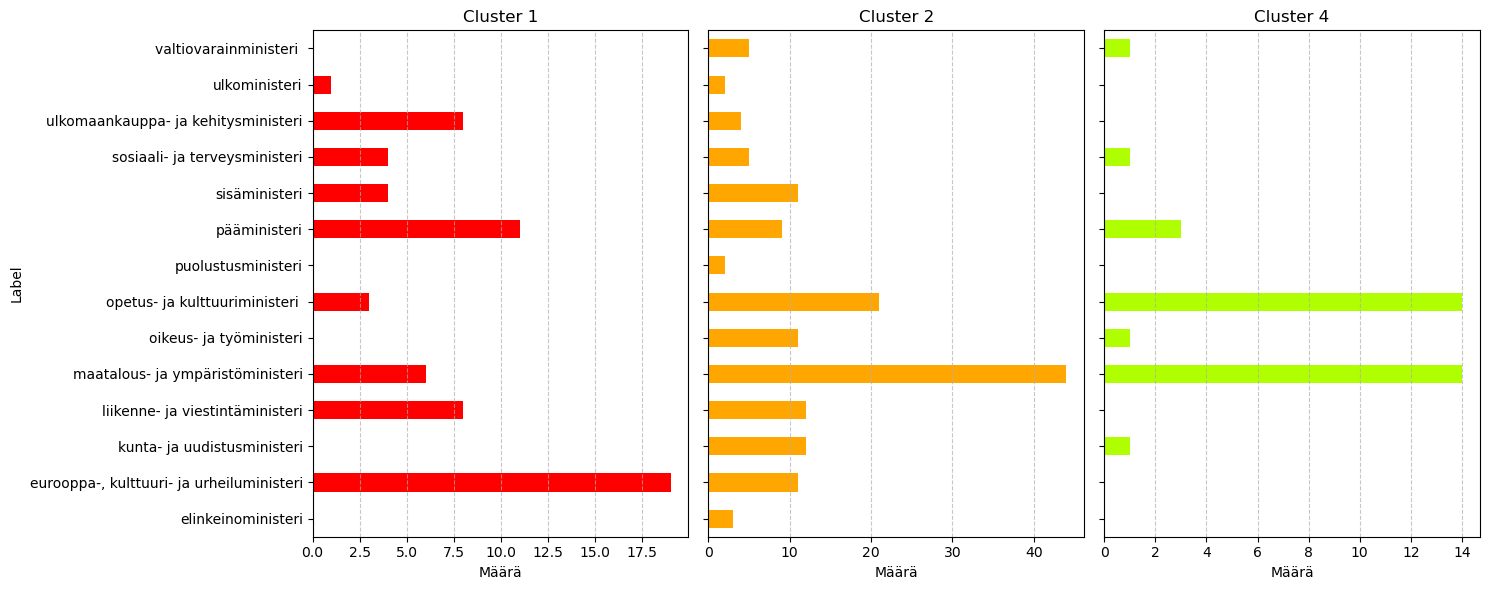

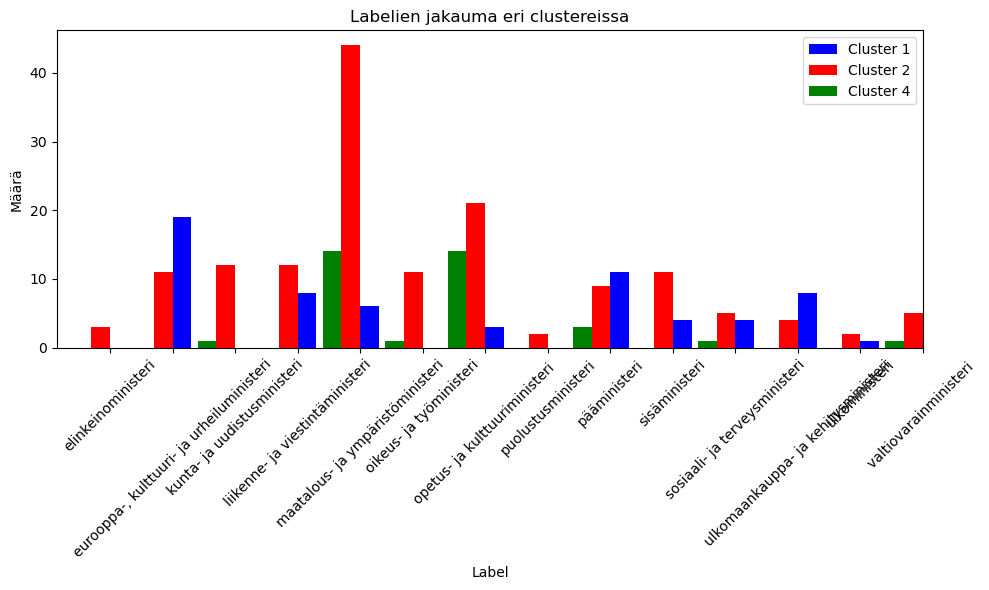

In [58]:
selected_clusters = [1, 2, 4]

tweets_filtered = tweets[tweets["cluster_id"].isin(selected_clusters)]

counts = tweets_filtered.groupby(["cluster_id", "label"]).size().unstack(fill_value=0)

# Plotataan klusterit kolmeen eri pylväsdiagrammiin vierekkäin
fig, axes = plt.subplots(1, 3, figsize=(15, 6), sharey=True)

# Cluster ID:t, värit ja otsikot
clusters = [1, 2, 4]
colors = ["blue", "red", "green"]

for i, cluster in enumerate(clusters):
    counts.loc[cluster].plot(kind="barh", ax=axes[i], color=color_map(i))
    axes[i].set_title(f"Cluster {cluster}")
    axes[i].set_xlabel("Määrä")  # X-akseli näyttää määrän
    axes[i].grid(axis="x", linestyle="--", alpha=0.7)

# Yhteinen Y-akselin otsikko
axes[0].set_ylabel("Label")
plt.tight_layout()
plt.show()

# Plotataan kuva
fig, ax = plt.subplots(figsize=(10, 6))

# Piirretään kolme pylväsdiagrammia
counts.loc[1].plot(kind="bar", ax=ax, position=0, width=0.3, label="Cluster 1", color="blue")
counts.loc[2].plot(kind="bar", ax=ax, position=1, width=0.3, label="Cluster 2", color="red")
counts.loc[4].plot(kind="bar", ax=ax, position=2, width=0.3, label="Cluster 4", color="green")

ax.set_ylabel("Määrä")
ax.set_xlabel("Label")
ax.set_title("Labelien jakauma eri clustereissa")
ax.legend()
plt.xticks(rotation=45)  # Käännetään x-akselin tekstit, jos niitä on paljon
plt.tight_layout()
plt.show()